# Importations

In [1]:
# Check which kernel 
import sys 

# Check python version 
print(sys.version)
# Check which executable 
print()
print(sys.executable)
# And what is in the path
print()
print(sys.path) 

3.13.5 | packaged by Anaconda, Inc. | (main, Jun 12 2025, 16:09:02) [GCC 11.2.0]

/opt/anaconda3/envs/langevin/bin/python3.13

['/opt/anaconda3/envs/langevin/lib/python313.zip', '/opt/anaconda3/envs/langevin/lib/python3.13', '/opt/anaconda3/envs/langevin/lib/python3.13/lib-dynload', '', '/opt/anaconda3/envs/langevin/lib/python3.13/site-packages']


In [2]:
# sys.path.insert(0, '/path/to/other/env/lib/python3.9/site-packages')

In [52]:
import numpy as np

# import pandas as pd

import sys
import time
from tqdm import tqdm

# from scipy.io import loadmat, savemat
# import scipy.stats
# from scipy.stats import levy
from scipy.optimize import curve_fit

In [4]:
from simulations.langevin.DoubleWalls_Overdamped_Langevin import DoubleWallsLangevin

In [5]:
import simulations.langevin.ComputeObservables as co

In [189]:
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpltools import annotation
from matplotlib import rc
import seaborn as sns
custom_params = {
    "xtick.direction": "in",
    "ytick.direction": "in",
    "lines.markeredgecolor": "k",
    "lines.markeredgewidth": 0.3,
    "figure.dpi": 500,
    "text.usetex": True,
    "font.family": "serif",
}

sns.set_theme(context = "notebook", style="ticks", rc=custom_params)

BlueUB = (0, 157/255, 224/255)
BrownUB = (68/255, 58/255, 49/255)

# Some auxiliary functions

In [7]:
def compute_lB(a, drho, kT=4e-21, g=9.81):
    return kT / (4/3*np.pi*a**3*drho*g)

In [8]:
# Here z is the gap between the particle and the (bottom) wall

def diffusing_diffusivity_z(z, a):
    res = (6*(z**2) + 2*a*z) / (6*(z**2) + 9*a*z + 2*(a**2))
    return res

def diffusing_diffusivity_x(z, a):
    ksi = a / (a + z)
    res = (1 - (9/16)*(ksi) + (1/8)*(ksi**3) - (45/256)*(ksi**4) + (1/16)*(ksi**5))
    return res

# Global variables

In [9]:
kb = 1.38e-23
T = 293
kT = kb * T
print(kT)

4.0434e-21


# Test one simulation

In [232]:
# Parameters

H = 100e-6

a = 1.48e-6

H -= a # to be checked again

rho_m = 1000
rho_p = 1050
drho = rho_p - rho_m

lB = compute_lB(a = a, drho = drho)
print('Boltzmann length = {} nm'.format(lB * 1e9))

lD = 20e-9
B = 4.5

eta0 = 0.001

dt = 0.001
Nt = 1_000_000

Boltzmann length = 600.5473074094804 nm


In [233]:
# Simulation 
tc_0 = time.time() 
brown = DoubleWallsLangevin(
    dt=dt, Nt=Nt, Nt_sub=1, 
    a=a, H=H, lD=lD, lB=lB, B=B, eta0=eta0, T=T, 
    R0=None, #(0,-H + a + lB),
)
brown.trajectory() #Compute trajectory of "brown"
print("Compute time = ", time.time()-tc_0)

Compute time =  10.044780015945435


In [234]:
x = brown.Xn
z = brown.Zn + H
tps = np.arange(len(z)) * dt

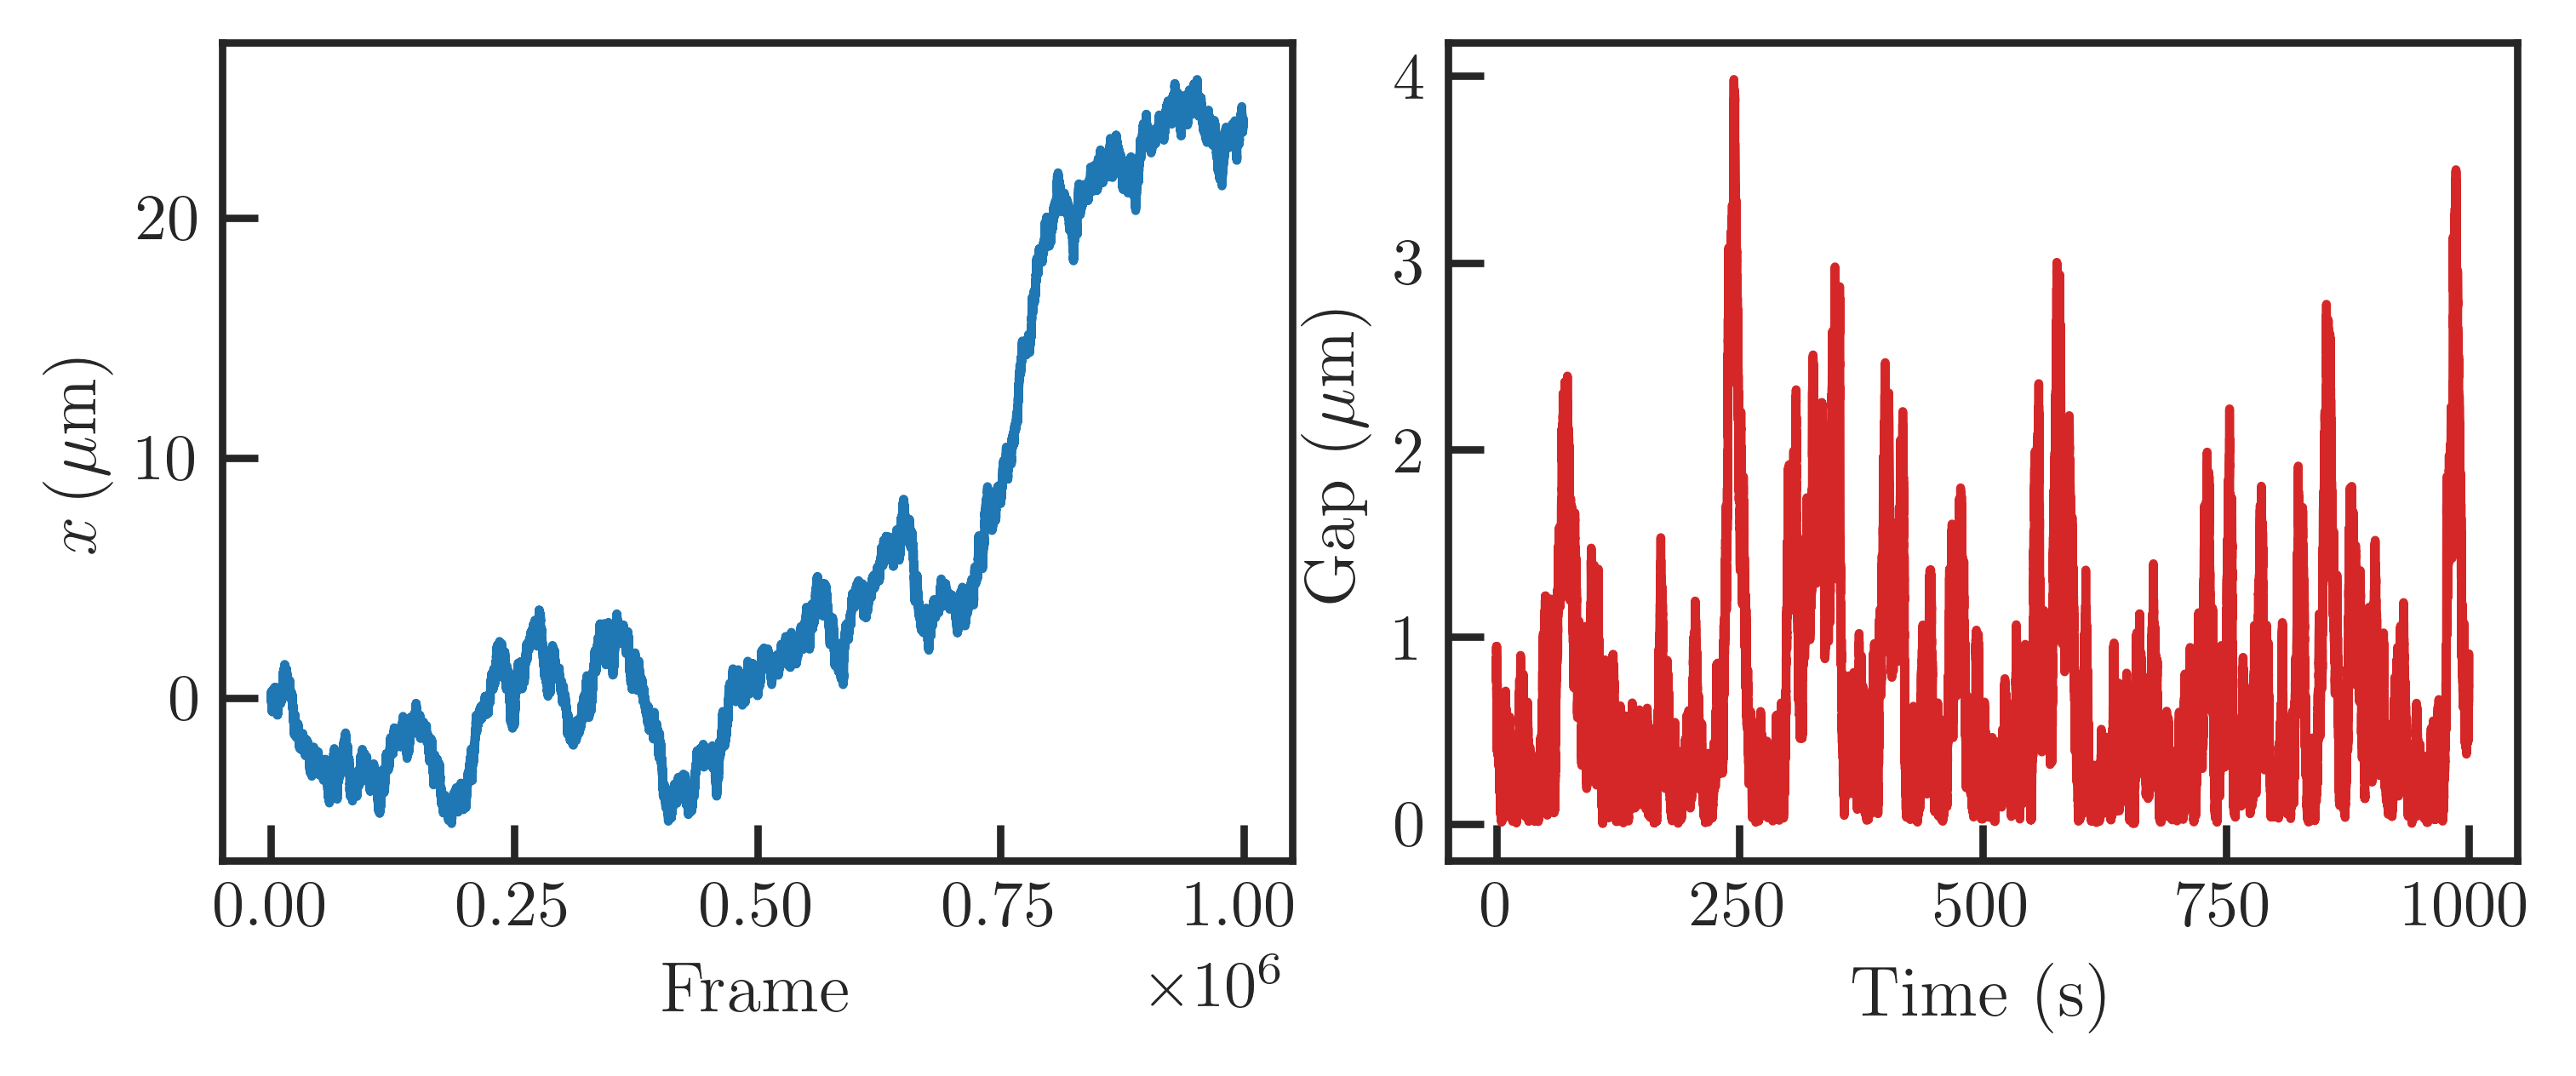

In [235]:
fig, axes = plt.subplots(1, 2, figsize=(15/2.54, 6/2.54))

axes[0].plot(x*1e6, color = 'tab:blue')
axes[0].set(xlabel='Frame', ylabel=r'$x \, (\mathrm{\mu m})$')
axes[1].plot(tps, z*1e6, color = 'tab:red')
axes[1].set(xlabel='Time (s)', ylabel=r'Gap $(\mathrm{\mu m})$')

plt.tight_layout(pad=0.1)
plt.show()
# fig.savefig('traj.pdf')

In [236]:
# Compute MSDs

delta_frame_nb = np.concatenate(
    (
        np.arange(1, 10, 1),
        np.arange(10, 100, 10),
        np.arange(100, 1000, 100),
        np.arange(1000, 70000, 1000),
    )
)

delta_time_MSD = tps[delta_frame_nb]

MSD_x, std_MSD_x = co.moment(2, x, delta_frame_nb, return_std = True, retrieve_mean = True) # Function in wrapper
MSD_z, std_MSD_z = co.moment(2, z, delta_frame_nb, return_std = True, retrieve_mean = True)

D0 = kT / (6*np.pi*eta0*a)

start = 0
stop = 10
coef_MSD_x = np.polyfit(delta_time_MSD[start:stop], MSD_x[start:stop], 1)
coef_MSD_z = np.polyfit(delta_time_MSD[start:stop], MSD_z[start:stop], 1)
meanDx_MSD = coef_MSD_x[0] / 2
meanDz_MSD = coef_MSD_z[0] / 2

In [237]:
def _P_eq(z, B, lD, lB):
    return np.exp(-B * np.exp(-z / lD) - z / lB)

def P_eq(z, B, lD, lB, normalize=True):
    if type(z) == float:
        if z < 0:
            res = 0
        return _P_eq(z, B, lD, lB)
    res = _P_eq(z, B, lD, lB)
    res[z < 0] = 0
    if normalize:
        res = res / np.trapezoid(res, z) # Ok because it is a change of variable
    return res

In [238]:
zz = np.linspace(1e-9, 10e-6, int(1e6))
meanDx = np.trapezoid(P_eq(zz, B, lD, lB) * diffusing_diffusivity_x(zz, a), zz) * D0
meanDz = np.trapezoid(P_eq(zz, B, lD, lB) * diffusing_diffusivity_z(zz, a), zz) * D0

In [239]:
meanDx

np.float64(8.612523039624089e-14)

In [240]:
meanDx_MSD

np.float64(7.984190294462058e-14)

In [241]:
# Compute Peq

# The error on the PDF and the equilibrium force is estimated by:
# Adding a nanometric noise to the trajectory, several times.

n_noisy = 100 # Number of iterations of the noise-adding procedure
min_distance = 50e-9 
max_distance = 2e-6
n_bins = 30

data_P_eq, data_F_eq = co.PeqFeq(z, n_noisy, min_distance, max_distance, n_bins)
# PeqFeq returns two dictionnaries, containing data corresponding to Peq and Feq

x_P_eq, width_P_eq, y_P_eq, std_y_P_eq, err_y_P_eq = data_P_eq.values()
x_F_eq, width_F_eq, y_F_eq, std_y_F_eq, err_y_F_eq = data_F_eq.values()

del data_P_eq, data_F_eq

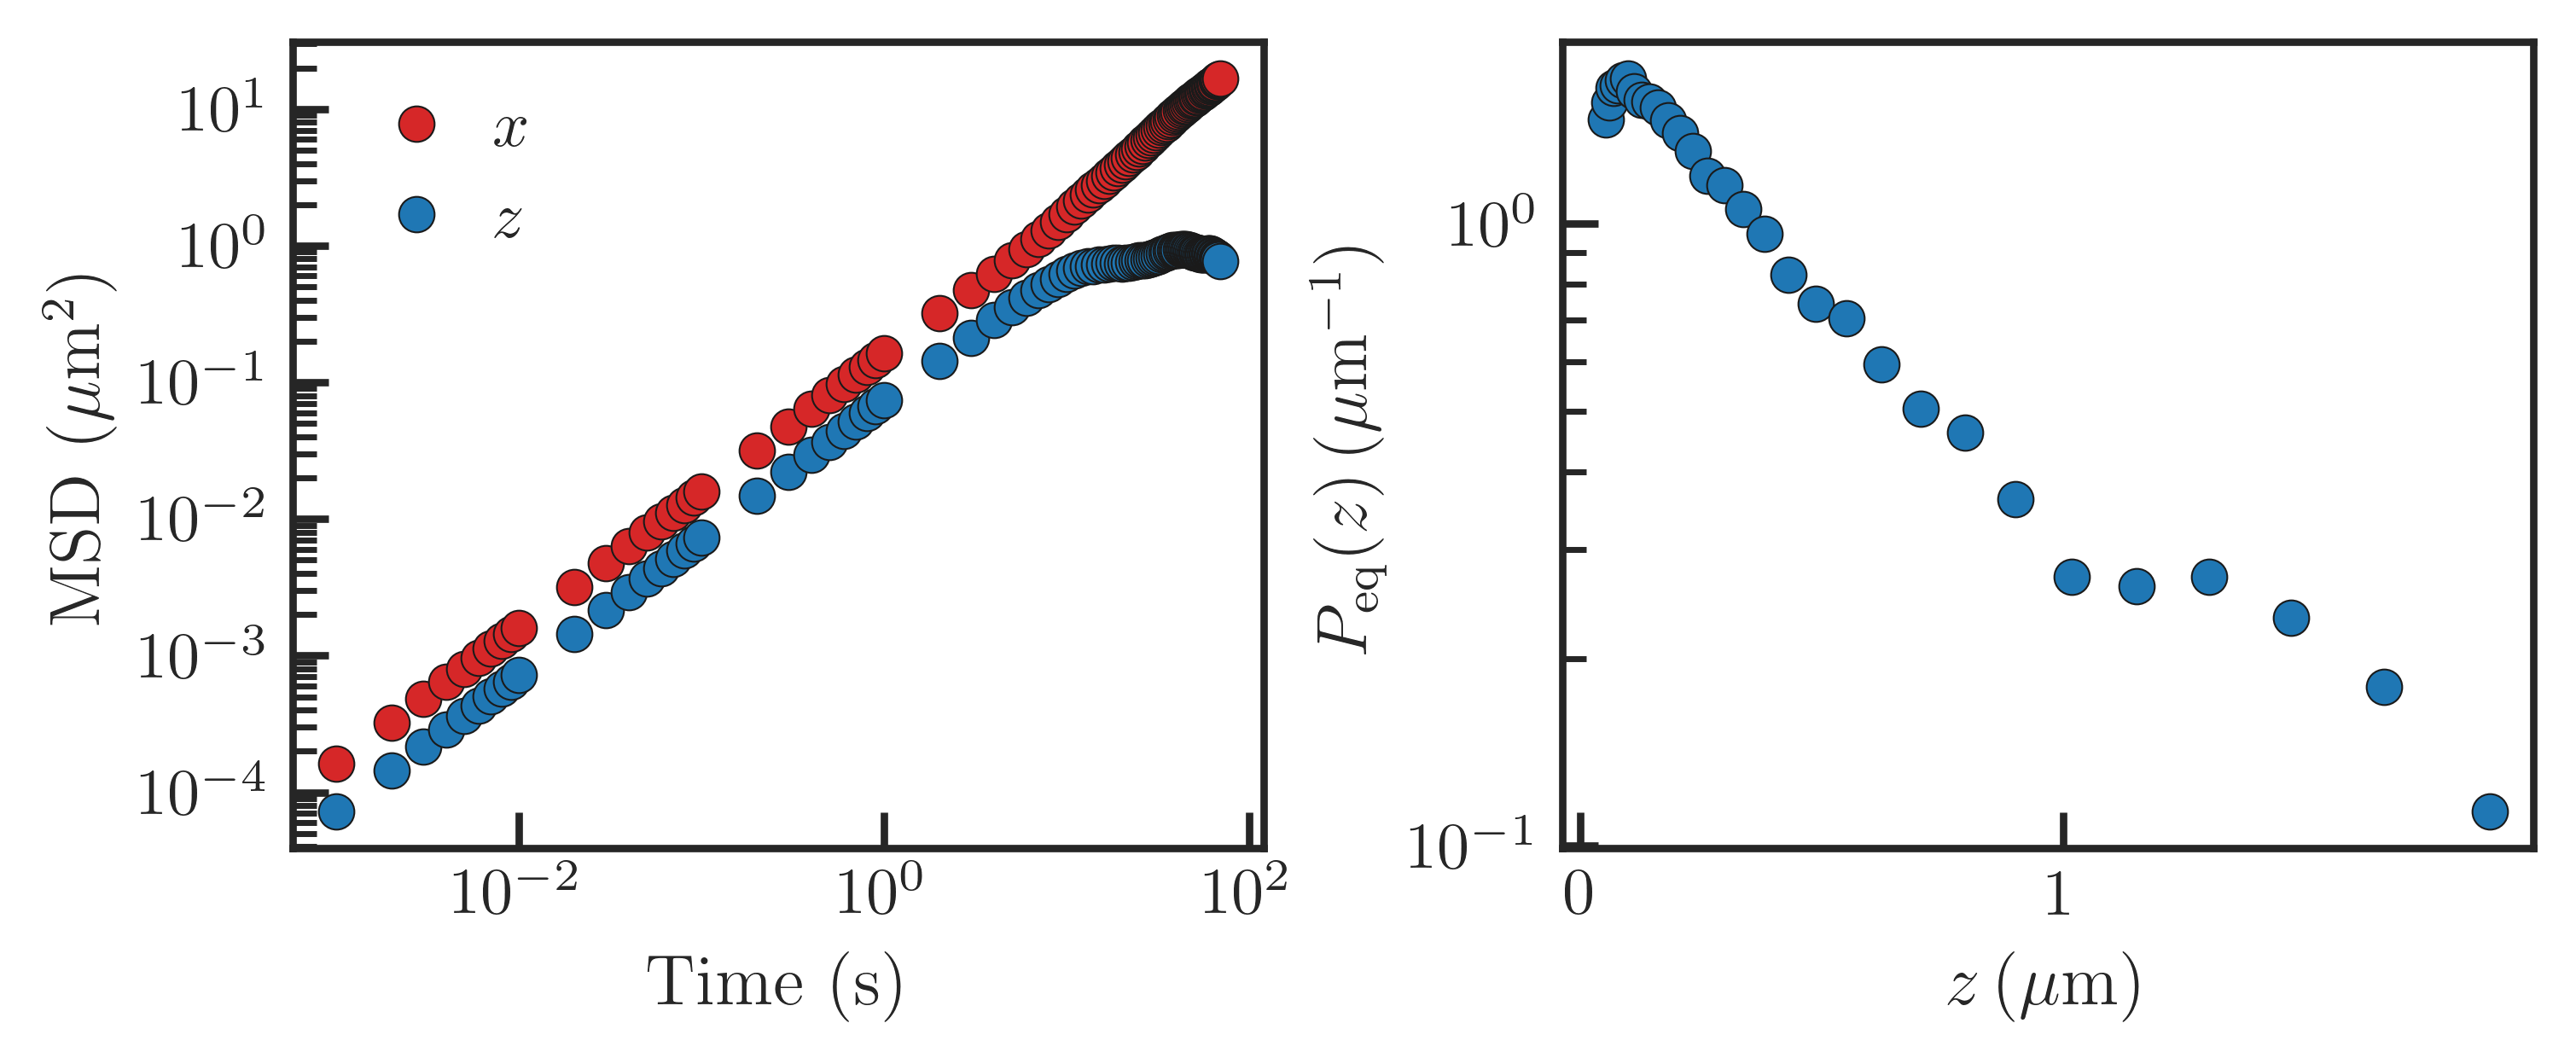

In [242]:
# Plot 

fig, axes = plt.subplots(1, 2, figsize=(15/2.54, 6/2.54))

axes[0].plot(delta_time_MSD, MSD_x*1e12, 'o', mfc='tab:red', label=r'$x$')
axes[0].plot(delta_time_MSD, MSD_z*1e12, 'o', mfc='tab:blue', label=r'$z$')
axes[0].legend(frameon=False, handletextpad=0.2)
axes[0].set(xlabel='Time (s)', ylabel=r'MSD $(\mathrm{\mu m ^2})$', xscale='log', yscale='log')
axes[1].plot(x_P_eq*1e6, y_P_eq*1e-6, 'o', mfc='tab:blue')
axes[1].set(xlabel=r'$z \, \mathrm{(\mu m)}$', ylabel=r'$P_\mathrm{eq}(z) \, \mathrm{(\mu m ^{-1})}$', xscale='linear', yscale='log')

plt.tight_layout(pad=0.2)
plt.show()

In [18]:
# Compute FPTs

def get_FPT_naive(x, dt, L=500e-9):
    Ntot = len(x)
    res = []
    for i in tqdm(range(Ntot)):
        x0 = x[i]
        j = i
        c = 0
        while x[j] < x0 + L:
            j += 1
            c += 1
            if j >= Ntot:
                break
        if j < Ntot:
            res.append(c)
    res = np.array(res)
    res = res * dt
    return res 

In [57]:
L = 300e-9

FPT_x = get_FPT_naive(x, dt=dt, L=L)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [02:05<00:00, 796.77it/s]


In [72]:
bins_FPT_x, _, hist_FPT_x = co.logarithmic_hist(FPT_x, begin=np.min(FPT_x), stop=np.max(FPT_x), num=30, base=10)

In [64]:
from math import sqrt

def Levy(t, L, D, x0=0):
    res = abs(L - x0) / np.sqrt(4*np.pi*D*t**3) * np.exp(-(L - x0)**2 / (4*D*t)) 
    return res

# def Levy(t, c, x0=0):
#     res = np.sqrt(c / 2 / np.pi) / t ** (3/2) * np.exp(-c / 2 / t) 
#     return res

In [116]:
bins_FPT_x_theory = np.logspace(-2, np.log10(3e1), 1000)
hist_FPT_x_theory = Levy(bins_FPT_x_theory, L=300e-9, D=meanDx_MSD)
# hist_FPT_x_theory = Levy(bins_FPT_x_theory, )

In [117]:
popt, _ = curve_fit(lambda t, D: Levy(t, L=L, D=D), bins_FPT_x, hist_FPT_x, p0=[meanDx])

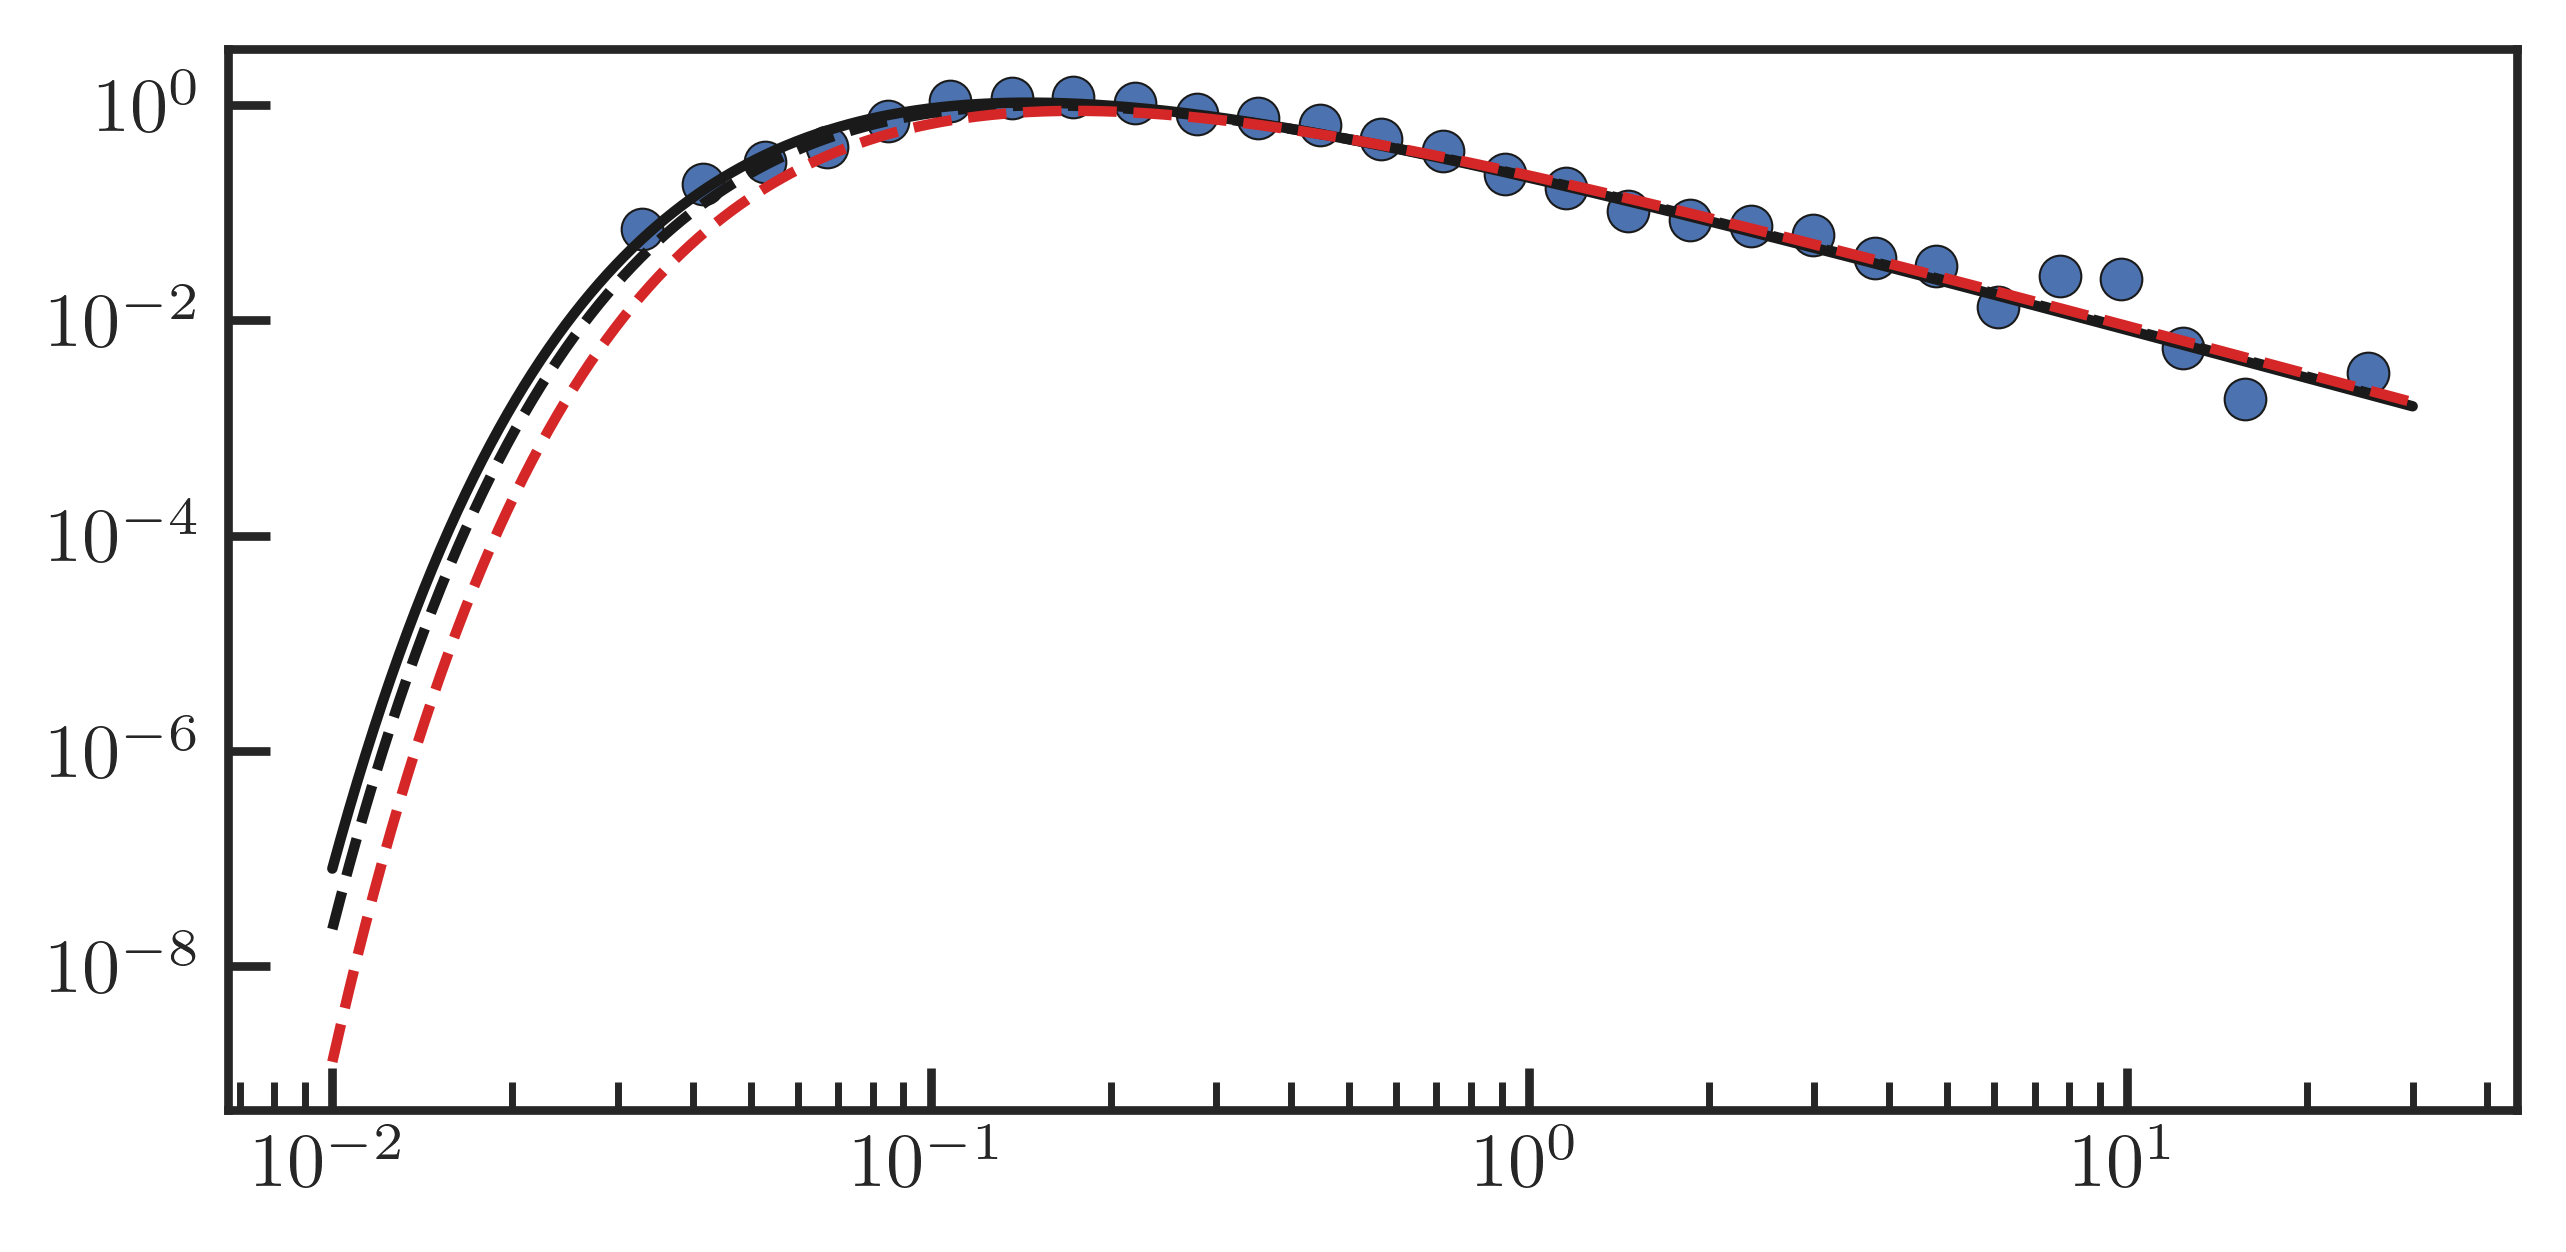

In [190]:
fig, ax = plt.subplots(1, 1, figsize=(15/2.54, 7/2.54))
plt.loglog(bins_FPT_x, hist_FPT_x, 'o')
plt.plot(bins_FPT_x_theory, hist_FPT_x_theory, '--k')
plt.plot(bins_FPT_x_theory, Levy(bins_FPT_x_theory, L=L, D=popt[0]), '-k')
plt.plot(bins_FPT_x_theory, Levy(bins_FPT_x_theory, L=300e-9, D=meanDx), '--', c='tab:red')
plt.tight_layout()
plt.show()

In [69]:
print(meanDx)

8.613672165590654e-14


In [70]:
print(popt[0])

1.0271939032399151e-13


In [183]:
l = 300e-9
traj = np.copy(x)
Ntot = len(traj)
frames = np.arange(Ntot)

def get_FPT_naive(i):
    """
    Returns the time to reach x0+l, starting from one position x0.
    The position x0 corresponds to x[i], with i a time step of the trajectory. 
    """
    Ntot = len(traj)
    x0 = traj[i]
    j = i
    c = 0
    while traj[j] < x0 + l:
        j += 1
        c += 1
        if j >= Ntot:
            break
    if j >= Ntot:
        return np.nan
    res = c * dt 
    return res

def _get_FPT(n_proc):
    """
    Returns the distributions of FPTs, for one distance L. 
    Computed over n_proc CPUs.
    """
    # traj = np.copy(x) #self.choose_traj(direction=direction)
    # f = lambda i: get_FPT_naive(traj, i, l=300e-9)
    # Ntot = len(traj)
    # frames = np.arange(Ntot)
    with Pool(n_proc) as p:
        res = p.map(get_FPT_naive, frames)
    res = np.array(res)
    res = res[~np.isnan(res)]
    return res

In [186]:
%%time

test = _get_FPT(20)

CPU times: user 153 ms, sys: 122 ms, total: 275 ms
Wall time: 14.4 s


In [245]:
class FirstPassageTime():
    def __init__(self, x, z, dt, L):
        self.x = x
        self.z = z
        self.dt = dt
        self.Ntot = len(x)
        self.frames = np.arange(self.Ntot)
        self.tps = self.frames * dt
        self.L = L
        self.fptx = [[] for k in self.L]
        self.fptz = [[] for k in self.L]

    def choose_traj(self, direction='x'):
        if direction == 'x':
            traj = self.x
        elif direction == 'z':
            traj = self.z
        else: 
            print('Wrong direction! The direction x was used.')
        return traj 
        
    def get_FPT_naive(self, traj, i, l):
        """
        Returns the time to reach x0+l, starting from one position x0.
        The position x0 corresponds to x[i], with i a time step of the trajectory. 
        """
        x0 = traj[i]
        j = i
        c = 0
        while traj[j] < x0 + l:
            j += 1
            c += 1
            if j >= self.Ntot:
                break
        if j >= self.Ntot:
            return np.nan
        res = c * dt 
        return res

    def _get_FPT(self, k, direction='x'):
        """
        Returns the distributions of FPTs, for one distance L. 
        Computed over n_proc CPUs.
        """
        traj = self.choose_traj(direction=direction)
        f = lambda i: self.get_FPT_naive(traj, i, l=self.L[k])
        res = np.zeros_like(traj) * np.nan
        for i in tqdm(range(self.Ntot)):
            res[i] = f(i)
        res = res[~np.isnan(res)]
        return res
        
    def get_FPT(self, direction='x'):
        """
        Returns the distributions of FPTs for all the wanted distances L. 
        """
        res = [[] for k in range(len(self.L))]
        for k in tqdm(range(len(self.L))):
            fpt = self._get_FPT(k, direction=direction)
            res.append(fpt)
        res = np.array(res)
        return res

    def _get_FPT_parallel(self, k, n_proc, direction='x'):
        """
        Returns the distributions of FPTs, for one distance L. 
        Computed over n_proc CPUs.
        """
        traj = self.choose_traj(direction=direction)
        with Pool(n_proc, initializer=initializer, initargs=(traj, self.L[k])) as p:
            res = p.map(get_FPT_naive, self.frames)
        res = np.array(res)
        res = res[~np.isnan(res)]
        return res
        
    def get_FPT_parallel(self, n_proc, direction='x'):
        """
        Returns the distributions of FPTs for all the wanted distances L. 
        """
        res = [[] for k in range(len(self.L))]
        for k in tqdm(range(len(self.L))):
            fpt = self._get_FPT(k, n_proc=n_proc, direction=direction)
            res.append(fpt)
        res = np.array(res)
        return res

# Top-level function to compute FPTs
# Must be first-level to parallelize. 

# Variables that are parameters must be top-level too
traj = None
l = None

def initializer(x, target):
    global traj
    traj = x
    global l
    l = target

def get_FPT_naive(i):
    """
    Returns the time to reach x0+l, starting from one position x0.
    The position x0 corresponds to x[i], with i a time step of the trajectory. 
    """
    Ntot = len(traj)
    x0 = traj[i]
    j = i
    c = 0
    while traj[j] < x0 + l:
        j += 1
        c += 1
        if j >= Ntot:
            break
    if j >= Ntot:
        return np.nan
    res = c * dt 
    return res

In [246]:
fpt = FirstPassageTime(x, z, dt, L=[300e-9])

In [247]:
fpt.x

array([0.00000000e+00, 6.64972494e-09, 1.22651213e-08, ...,
       2.39222554e-05, 2.39097837e-05, 2.38850574e-05], shape=(1000000,))

In [196]:
# FPT_x = fpt._get_FPT(0)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [02:07<00:00, 786.22it/s]


In [248]:
%%time 

k = 0

FPT_x = fpt._get_FPT_parallel(0, 20)

CPU times: user 1.26 s, sys: 176 ms, total: 1.44 s
Wall time: 4min 36s


In [251]:
FPT_x

array([2.518, 2.518, 2.518, ..., 0.329, 0.34 , 0.34 ], shape=(994785,))

In [259]:
bins_FPT_x, _, hist_FPT_x = co.logarithmic_hist(FPT_x, begin=np.min(FPT_x), stop=np.max(FPT_x), num=30, base=10)

bins_FPT_x_theory = np.logspace(-2, np.log10(2e2), 1000)
hist_FPT_x_theory = Levy(bins_FPT_x_theory, L=fpt.L[k], D=meanDx_MSD)

popt, _ = curve_fit(lambda t, D: np.log10(Levy(t, L=L, D=D)), bins_FPT_x, np.log10(hist_FPT_x), p0=[meanDx]) # /!\ log fit

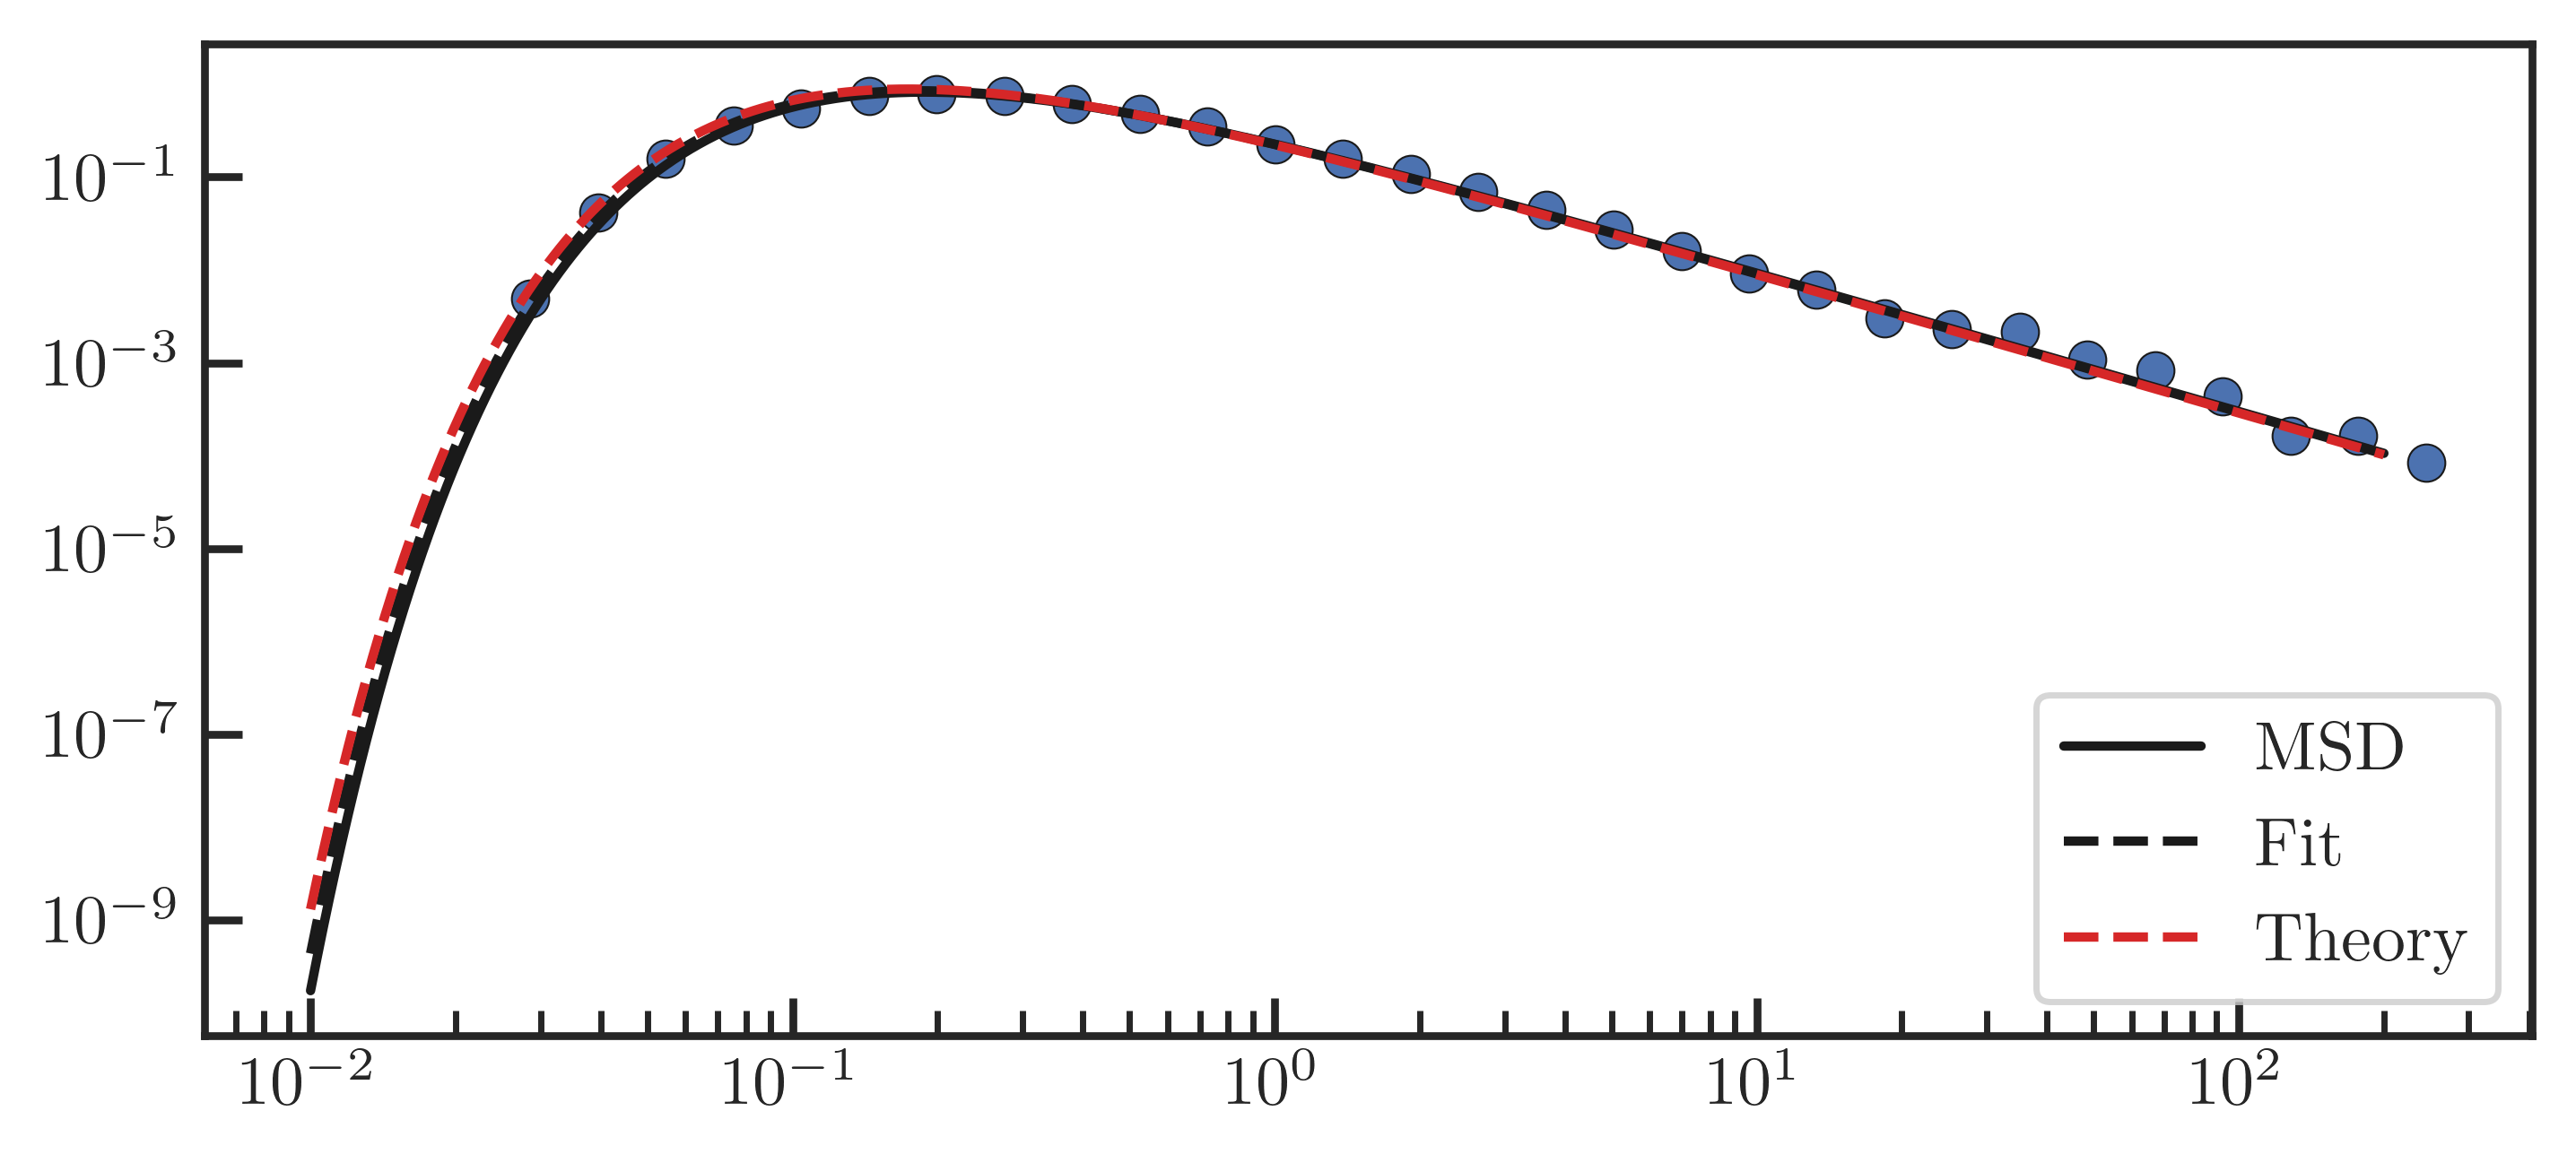

In [263]:
fig, ax = plt.subplots(1, 1, figsize=(15/2.54, 7/2.54))
ax.loglog(bins_FPT_x, hist_FPT_x, 'o')
ax.plot(bins_FPT_x_theory, hist_FPT_x_theory, '-k', label=r'MSD')
ax.plot(bins_FPT_x_theory, Levy(bins_FPT_x_theory, L=L, D=popt[0]), '--k', label='Fit')
ax.plot(bins_FPT_x_theory, Levy(bins_FPT_x_theory, L=fpt.L[k], D=meanDx), '--', c='tab:red', label='Theory')
ax.legend()
plt.tight_layout()
plt.show()

In [ ]:
# Rk 

# For a 100,000-point trajectory: 
# Computing FPTs:
# Serial = 2 min
# Parallel = 15 s

# For a 1,000,000-point trajectory:
# Parallel = 4 min 30 s

# CCL 
# Compute several short trajectories 
# Compute FPTs on each of them and concatenate distributions

# CCL regarding a 1,000,000-point trajectory 
# All the theories agrees better with each others, compared to one 100,000-point trajectory 